In [6]:
import finnhub
import yfinance as yf
from pprint import pprint
from datetime import timezone
import numpy as np
import pandas as pd
from datetime import date
import io
import matplotlib.pyplot as plt
from fastai.tabular.core import add_datepart
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import pyramid
from pmdarima.arima import auto_arima
import csv
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM
pd.options.mode.chained_assignment = None

In [7]:
key = "c5vd77qad3idg9amks2g"
finnhub_client = finnhub.Client(api_key=key)

In [8]:
df = pd.read_csv("data_small.csv")
newlist = df["name_of_stock"].values.tolist()
for i in range(len(newlist)):
    print(newlist[i])

AA
AACG
AAIC
AAL
AAN
AAOI
AAON
AAP
AAPL
AAT
AAWW
AB
ABB
ABBV


In [9]:
##historical data for stock prices
def gethistoricaldata(ticker, period = "max", interval = "1d"):
    return ticker.history(period = period, interval = interval)

In [10]:
def plot(df):
    #setting index as date
    df['date'] = df.index.format()

    #plot
    plt.figure(figsize=(16,8))
    plt.plot(df['Close'], label='Close Price history', color = "black")
    plt.savefig("vis1",dpi = 400)

In [11]:
def linear_reg(new_data):
    #split into train and validation
    train = new_data[:200]
    valid = new_data[200:]

    x_train = train.drop('Close', axis=1)
    y_train = train['Close']
    x_valid = valid.drop('Close', axis=1)
    y_valid = valid['Close']

    #implement linear regression
    model = LinearRegression()
    model.fit(x_train,y_train)
    preds = model.predict(x_valid)
    rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
    return rms, valid, train,preds

In [12]:
def knn(new_data):
    train = new_data[:200]
    valid = new_data[200:]

    x_train = train.drop('Close', axis=1)
    y_train = train['Close']
    x_valid = valid.drop('Close', axis=1)
    y_valid = valid['Close']
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
    knn = neighbors.KNeighborsRegressor()
    model = GridSearchCV(knn, params, cv=5)

    #fit the model and make predictions
    model.fit(x_train,y_train)
    preds = model.predict(x_valid)
    rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
    return rms, valid, train,preds

In [13]:
def arima(data):
    train = data[:200]
    valid = data[200:]

    training = train['Close']
    validation = valid['Close']

    model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
    model.fit(training)
    
    index_new = pd.date_range(start='2022-7-15', end='2022-09-4')
    forecast = model.predict(n_periods=52)
    forecast = pd.DataFrame(forecast,index = index_new,columns=['Prediction'])
    rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
    return rms,forecast,train,valid

In [14]:
#creating dataframe
# data = df.sort_index(ascending=True, axis=0)
def lstm(data, df):
    new_data = pd.DataFrame(index=range(0,len(df)),columns=['date', 'Close'])
    for i in range(0,len(data)):
        new_data['date'][i] = data['date'][i]
        new_data['Close'][i] = data['Close'][i]

    #setting index
    new_data.index = new_data.date
    new_data.drop('date', axis=1, inplace=True)

    #creating train and test sets
    dataset = new_data.values

    train = dataset[0:200,:]
    valid = dataset[200:,:]

    #converting dataset into x_train and y_train
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    x_train, y_train = [], []
    for i in range(60,len(train)):
        x_train.append(scaled_data[i-60:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

    #predicting 246 values, using past 60 from the train data
    inputs = new_data[len(new_data) - len(valid) - 60:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)

    X_test = []
    for i in range(60,inputs.shape[0]):
        X_test.append(inputs[i-60:i,0])
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
    return rms, closing_price

In [18]:
# Linear Regression Plot
def visualize_linear_reg(valid, train,preds, data, ticker_name):
    #valid['Predictions'] = 0
    #valid['Predictions'] = preds
    
    index_new = pd.date_range(start='2022-7-15', end='2022-09-4')
    valid.index = data[200:].index
    train.index = data[:200].index
    
    preds = pd.DataFrame(preds,index = index_new,columns=['Prediction'])
    plt.figure()
    plt.plot(train['Close'], color = "black")
    plt.plot(valid['Close'], color = "black")
    plt.plot(preds['Prediction'])
    #plt.plot(valid[['Predictions']])
    plt.savefig("lr_"+ ticker_name,dpi = 400)

In [19]:
# KNN plot
def visualize_knn(valid, train,preds, data, ticker_name):
    #valid['Predictions'] = 0
    #valid['Predictions'] = preds
    
    index_new = pd.date_range(start='2022-7-15', end='2022-09-4')
    valid.index = data[200:].index
    train.index = data[:200].index
    
    preds = pd.DataFrame(preds,index = index_new,columns=['Prediction'])
    plt.figure()
    plt.plot(train['Close'], color = "black")
    plt.plot(valid['Close'], color = "black")
    plt.plot(preds['Prediction'])
    #plt.plot(valid[['Predictions']])
    plt.savefig("knn_"+ ticker_name,dpi = 400)

In [20]:
# Arima plot
def visualize_arima(train,valid,forecast, ticker_name):
    plt.figure()
    plt.plot(train['Close'],color = "black")
    plt.plot(valid['Close'], color = "black")
    plt.plot(forecast['Prediction'])
    plt.savefig("arima_"+ ticker_name,dpi = 400)

In [21]:
# LSTM Plot
def visualize_lstm(new_data, closing_price, train,valid,ticker_name):
#     train = new_data[:200]
#     valid = new_data[200:]
    index_new = pd.date_range(start='2022-7-15', end='2022-09-4')
    closing = pd.DataFrame(closing_price,index = index_new,columns=['new'])
    # valid['Predictions'] = closing_price
    plt.figure()
    plt.plot(train['Close'],color = "black")
    plt.plot(valid['Close'],color = "black")
    plt.plot(closing['new'])
    plt.savefig("lstm_" + ticker_name,dpi = 400)

In [22]:
def operation(ticker_name):
    df = gethistoricaldata(yf.Ticker(ticker_name), period = "12mo", interval = "1d")
    # plot(df) - for simple ploting
    df['date'] = df.index.format()
    df['date'] = pd.to_datetime(df.date,format='%Y-%m-%d')
    df.index = df['date']

    data = df.sort_index(ascending=True, axis=0)

    #creating a separate dataset
    new_data = pd.DataFrame(index=range(0,len(df)),columns=['date', 'Close'])

    for i in range(0,len(data)):
        new_data['date'][i] = data['date'][i]
        new_data['Close'][i] = data['Close'][i]
    add_datepart(new_data, 'date')
    new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp
    rms1, valid_li, train_li,preds_li = linear_reg(new_data)
    print(rms1)
    visualize_linear_reg(valid_li, train_li,preds_li, data, ticker_name)
    rms2, valid_knn, train_knn,preds_knn = knn(new_data)
    print(rms2)
    visualize_knn(valid_knn, train_knn,preds_knn, data, ticker_name)
    rms3,forecast,train,valid = arima(data)
    print(rms3)
    visualize_arima(train,valid,forecast, ticker_name)
    rms4, closing_price = lstm(data, df)
    print(rms4)
    visualize_lstm(new_data, closing_price, train,valid, ticker_name)

In [23]:
plt.rcParams.update({'figure.max_open_warning': 0})

34.41462782260593
6.009996085600192
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1002.140, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=962.519, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1003.666, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=955.539, Time=0.16 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.02 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=953.541, Time=0.13 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=960.529, Time=0.04 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.14 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=955.539, Time=0.16 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=957.434, Time=0.31 sec
 ARIMA(0,1,0)(2,1,0

 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=169.413, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=100.535, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=171.343, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=90.916, Time=0.20 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.39 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=89.760, Time=0.16 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=99.344, Time=0.05 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.53 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=90.660, Time=0.17 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=85.197, Time=0.74 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=inf, Time=0.59 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=

 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=777.438, Time=0.33 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=771.688, Time=0.63 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=800.915, Time=0.19 sec
 ARIMA(2,1,0)(2,1,2)[12]             : AIC=772.931, Time=1.03 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=832.617, Time=0.07 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(3,1,0)(2,1,1)[12]             : AIC=772.655, Time=0.73 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=773.219, Time=0.99 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=774.237, Time=0.77 sec
 ARIMA(3,1,1)(2,1,1)[12]             : AIC=774.142, Time=1.14 sec
 ARIMA(2,1,0)(2,1,1)[12] intercept   : AIC=772.345, Time=0.77 sec

Best model:  ARIMA(2,1,0)(2,1,1)[12]          
Total fit time: 10.728 seconds
3.265771215907626
140/140 - 4s - loss: 0.0335 - 4s/epoch - 26ms/step
2/2 [=

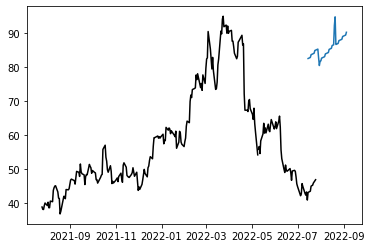

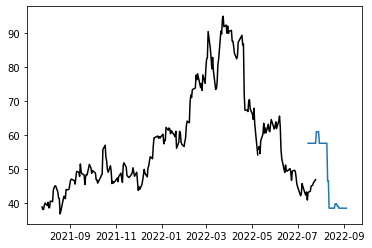

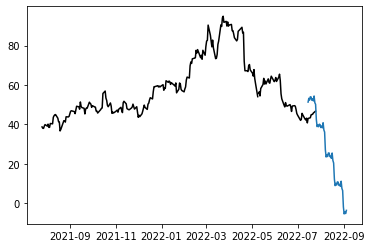

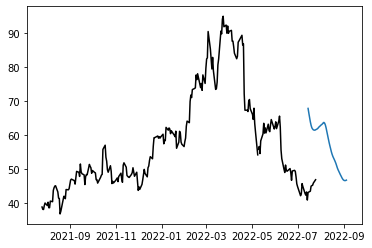

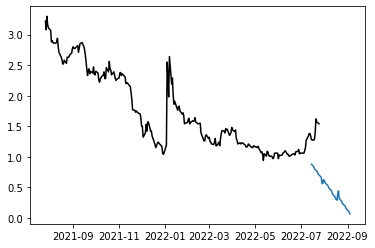

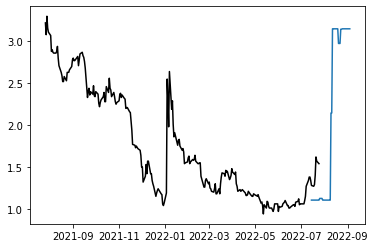

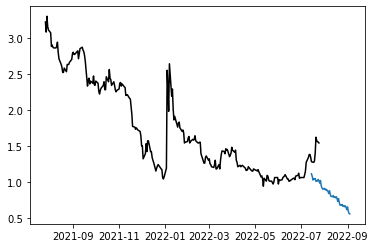

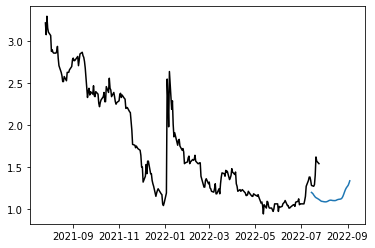

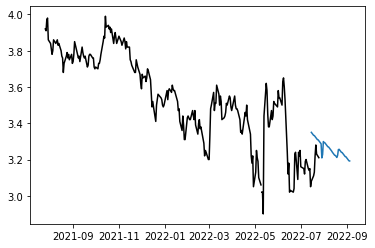

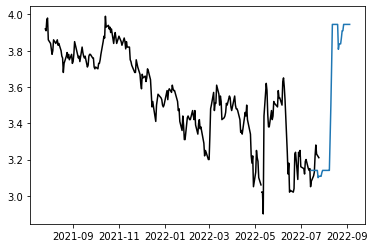

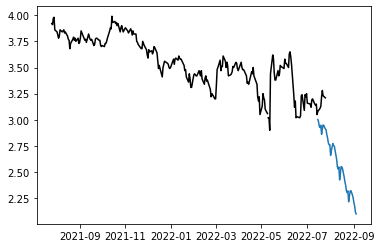

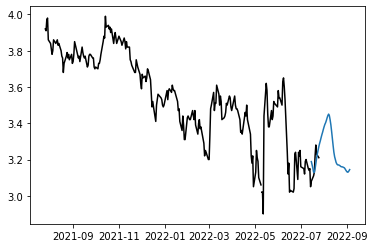

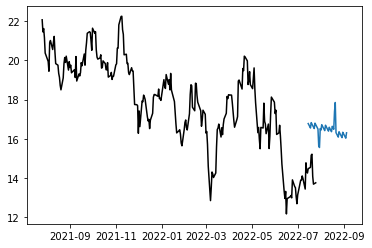

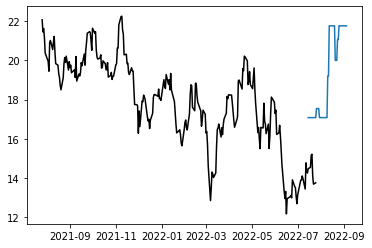

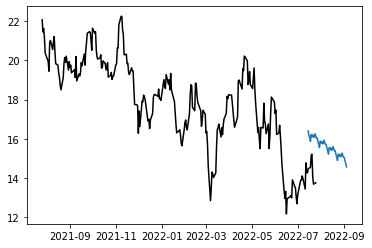

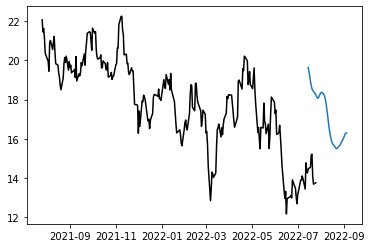

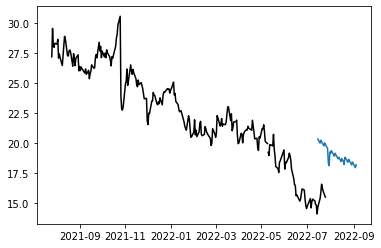

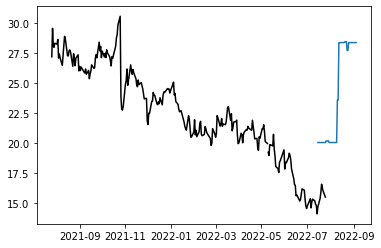

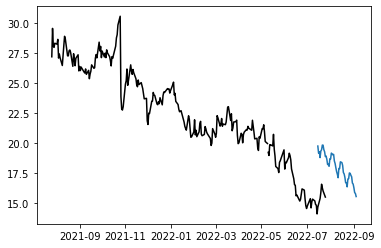

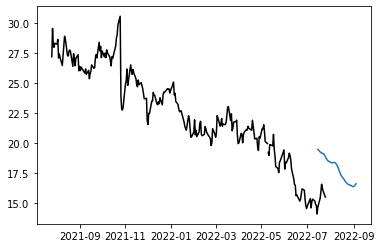

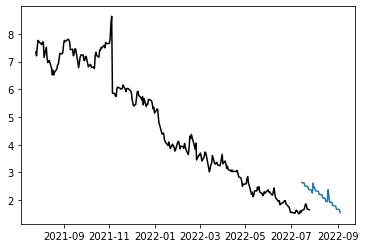

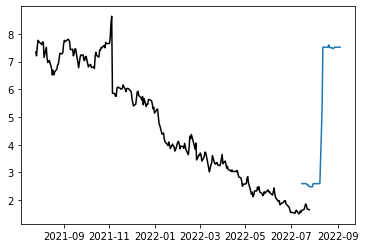

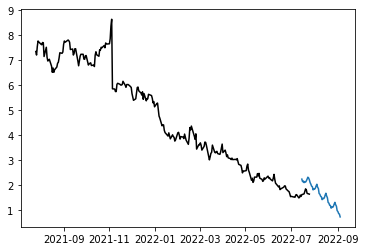

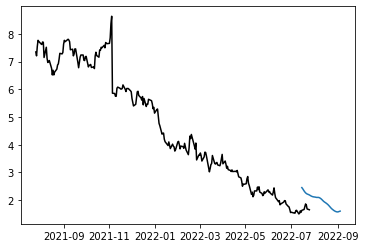

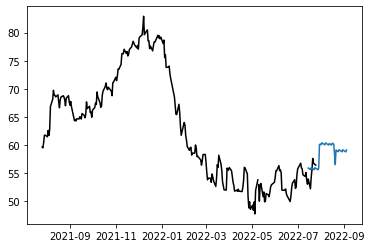

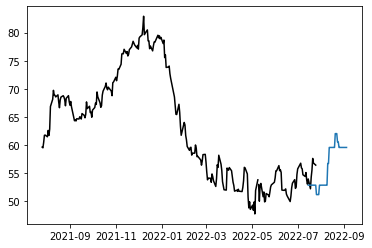

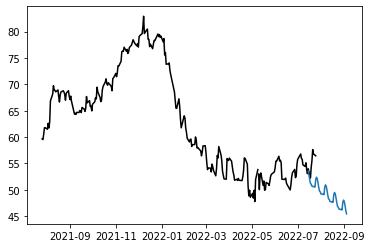

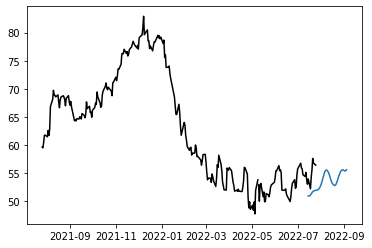

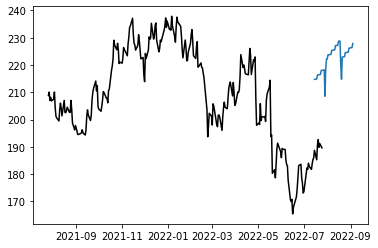

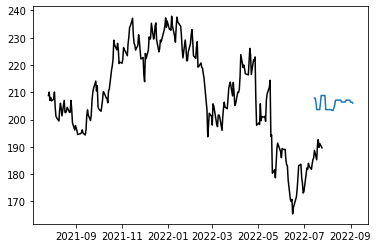

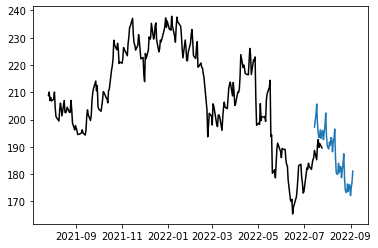

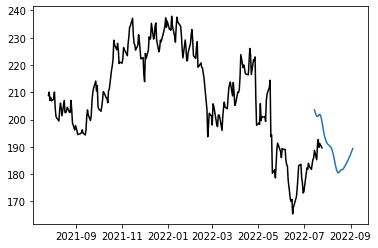

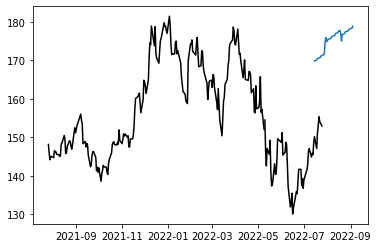

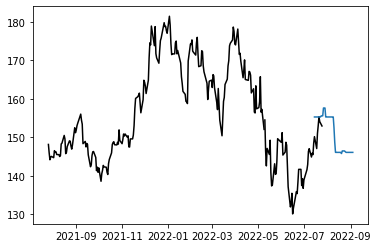

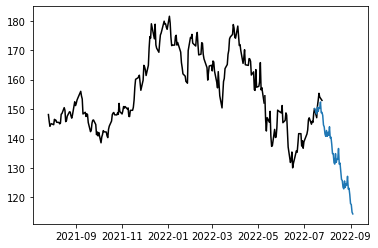

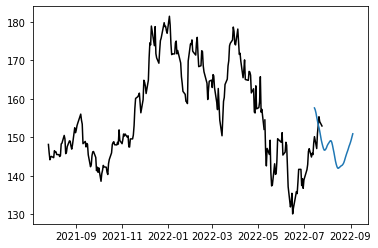

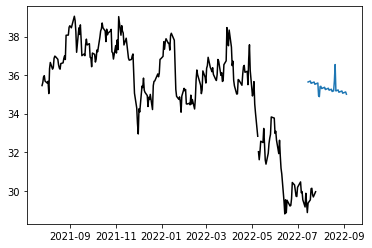

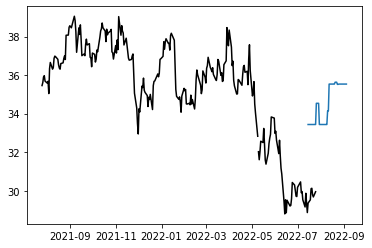

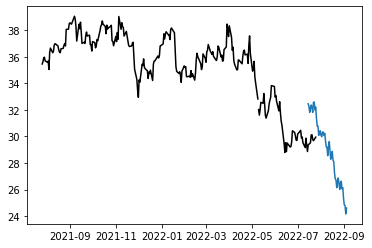

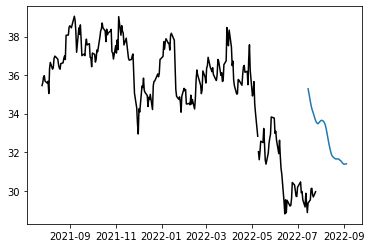

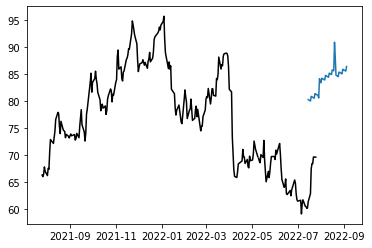

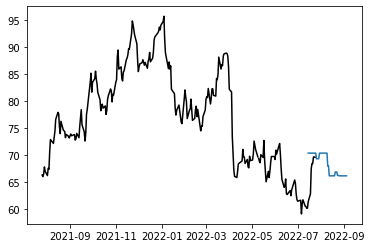

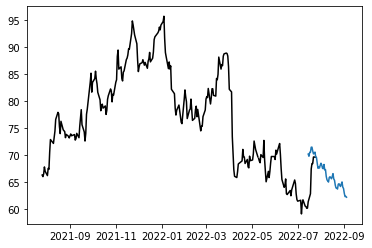

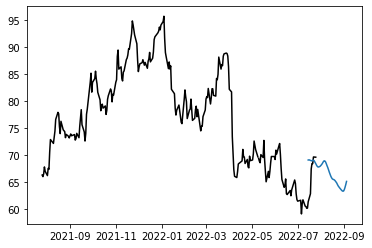

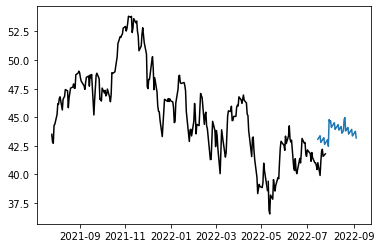

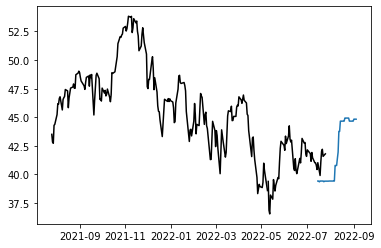

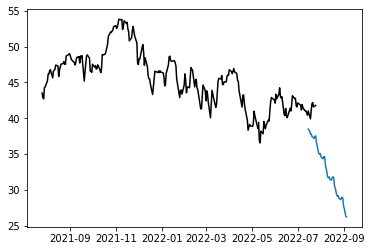

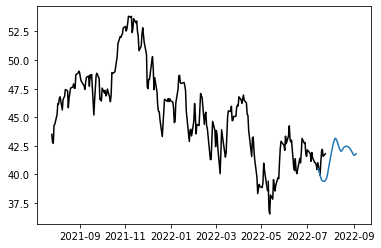

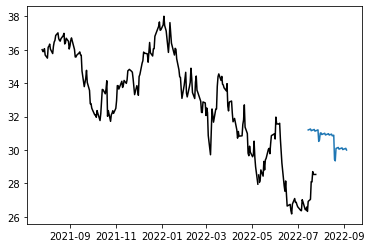

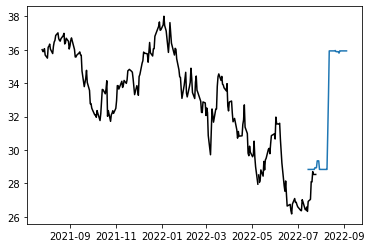

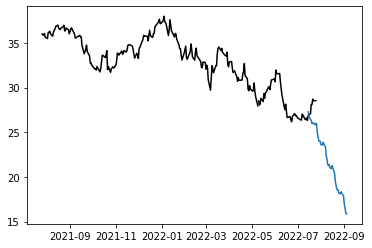

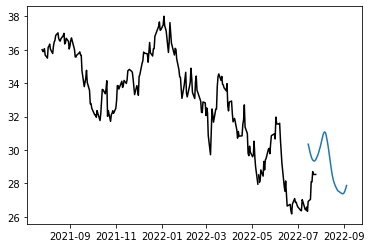

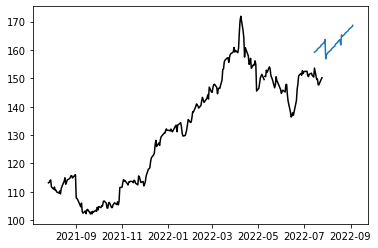

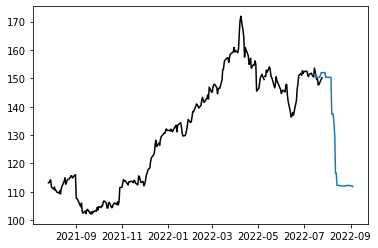

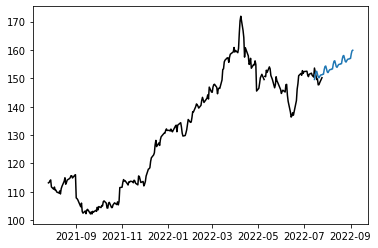

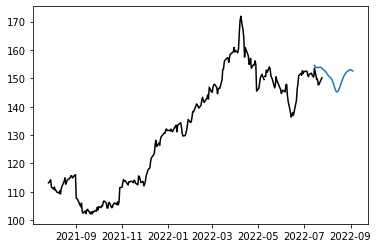

In [24]:
for i in range(len(newlist)):
#     if i == 2:
#         break
    try:
        operation(newlist[i])
    except Exception as e:
        print(e)